In [8]:
import numpy as np
import matplotlib.pyplot as plt

In [9]:
# a is current, b is upstream, c is downstream, d is source
def tdma(N, a, b, c, d, T, TW, TE):
    P = np.zeros(N)
    Q = np.zeros(N)

    # west BC, T[0] is known so P[0] = 0 and Q[0] is T[0]
    P[0] = 0
    Q[0] = TW

    # setting up the inside elements
    for i in range(1, N-1): 
        P[i] = b[i] / (a[i] - c[i] * P[i-1])
        Q[i] = (d[i] + c[i] * Q[i-1]) / (a[i] - c[i] * P[i-1])

    # east BC, T[N] is known
    P[N-1] = 0
    Q[N-1] = TE

    for i in range(N-2, -1, -1): # backwards solve
        T[i] = P[i] * T[i+1] + Q[i]

    return T.copy()

def analytical(grid, L, Pe):
    return 100 + ((np.exp(grid * Pe / L) - 1) / (np.exp(Pe) - 1) * (20-100))

def error_calc(grid, analytical, numerical):
    return 100 * (sum(abs((numerical - analytical)/analytical)) / grid)

def plotting(grid, analytical_results, title, scheme_results, error_value, Pe_G, Pe_L):
    fig, ax = plt.subplots() # values are rounded for display, not processing
    ax.plot(grid, analytical_results, label=f'Analytical', c='black')
    ax.plot(grid, scheme_results, label=f'Numerical, Error:{round(error_value,2)}%', 
            c='blue', ls='--', marker='o', mfc='red') 

    ax.set_title(f"{title} \n Pe Global: {Pe_G}, Pe Local: {round(Pe_L,3)}")
    ax.set_xlabel('x / L')
    ax.set_ylabel('Temperature (°C)')
    ax.legend()

    return plt.show()

In [10]:
def cds(N, gamma, dx, rho, u, T, TW, TE):
    aP = np.zeros(N)
    aE = np.zeros(N)
    aW = np.zeros(N)
    b = np.zeros(N)
    for i in range(1,N-1):
        aE[i] = gamma / dx - 0.5 * rho * u
        aW[i] = gamma / dx + 0.5 * rho * u
        aP[i] = aE[i] + aW[i] + b[i]

    return tdma(N, aP, aE, aW, b, T, TW, TE)

def uds(N, gamma, dx, rho, u, T, TW, TE):
    aP = np.zeros(N)
    aE = np.zeros(N)
    aW = np.zeros(N)
    b = np.zeros(N)
    for i in range(1, N-1):
        aE[i] = gamma / dx + max(-(rho * u), 0)
        aW[i] = gamma / dx + max((rho * u), 0)
        aP[i] = aE[i] + aW[i] + b[i]

    return tdma(N, aP, aE, aW, b, T, TW, TE)

def pds(N, gamma, dx, rho, u, T, TW, TE, Pe):
    aP = np.zeros(N)
    aE = np.zeros(N)
    aW = np.zeros(N)
    b = np.zeros(N)
    for i in range(1, N-1):
        aE[i] = (gamma / dx) * max((1 - 0.1 * abs(Pe))**5,0) + max(-(rho * u), 0)
        aW[i] = (gamma / dx) * max((1 - 0.1 * abs(Pe))**5,0) + max((rho * u), 0)
        aP[i] = aE[i] + aW[i] + b[i]
        
    return tdma(N, aP, aE, aW, b, T, TW, TE)

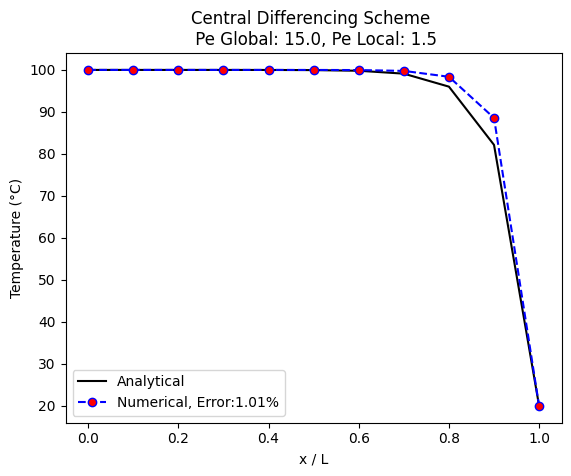

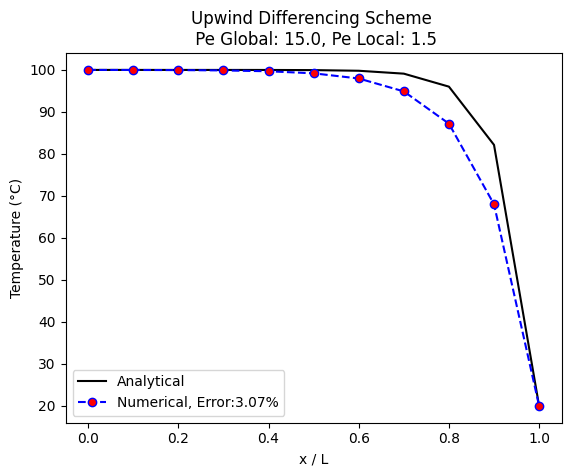

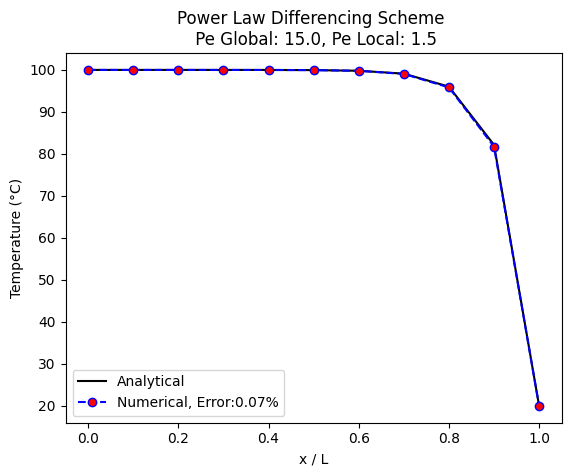

<generator object solve.<locals>.<genexpr> at 0x000002C76E401780>

In [ ]:
def solve(length, cell_count, gamma_T, density, vel, T_West, T_East):
    # Domain setup
    delta_x = length / (cell_count - 1)
    x = np.linspace(0, length, cell_count) 
    Temp = np.full(cell_count, T_East) # deg C

    # Equations Setup, do not round the values
    Pe_global = (density * vel * length / gamma_T)
    Pe_local = (density * vel * delta_x / gamma_T)
    T_analytical = analytical(x, length, Pe_global)

    # note the order for solving in for loop at the end
    schemes = ["Central Differencing Scheme",
                "Upwind Differencing Scheme",
                "Power Law Differencing Scheme",]
    results = [cds(cell_count, gamma_T, delta_x, density, vel, Temp, T_West, T_East), 
                uds(cell_count, gamma_T, delta_x, density, vel, Temp, T_West, T_East), 
                pds(cell_count, gamma_T, delta_x, density, vel, Temp, T_West, T_East, Pe_local)]
    errors = [error_calc(cell_count, T_analytical, res) for res in results]

    figures = []
    for i, j, k in zip(schemes, results, errors):
        figure = plotting(x, T_analytical, i, j, k, Pe_global, Pe_local)
        figures.append(figure)
        
    return (i for i in figures)

solve(length = 1.0, cell_count = 11, # domain setup
      gamma_T = 0.1, density = 1.0, # fluid properties
      vel = 1.5, T_West=100, T_East=20) # boundary conditions